In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pickle
import tensorflow as tf
import os
import argparse
import shutil
from itertools import repeat
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from pathlib import Path
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import seaborn as sns
#!pip install wfdb
import wfdb
import random
from tensorflow import keras
from keras.models import load_model
import keras
import scipy.signal

In [9]:
kernel = 3
emb_depth = 1
embedding = 16
transformer_layers = 1
hidden_size = 2 # key dim in attention layer
num_heads =  8
mlp_dim = 128
overwrite = 0
random_seed=0
batch_size=128
half_window = 99
use_cls_token = 0
cat_RR = 1
class_types = ['N', 'S', 'V', 'F', 'Q']


In [10]:

#############################################################################################################
#Model definition

def generate_patch_conv_orgPaper_f(embedding, inputs):
  patches = layers.Conv2D(filters=embedding, kernel_size=[kernel,1], strides=[kernel,1], padding='valid',input_shape=inputs.shape[1:])(inputs)
  for i in range(emb_depth-1):
    patches = layers.BatchNormalization()(patches)
    patches = layers.Conv2D(filters=embedding, kernel_size=[kernel,1], strides=[kernel,1], padding='valid',input_shape=patches.shape)(patches)
  row_axis, col_axis = (1, 2) # channels last images
  seq_len = (patches.shape[row_axis]) * (patches.shape[col_axis])
  x = tf.reshape(patches, [-1, seq_len, embedding])
  return x


class AddPositionEmbs(layers.Layer):
  """Adds (optionally learned) positional embeddings to the inputs."""

  def __init__(self, posemb_init=None, **kwargs):
    super().__init__(**kwargs)
    self.posemb_init = posemb_init

  def get_config(self):
        config = super().get_config().copy()
        config.update({
            'posembed_input': self.posemb_init
        })
        return config

  def build(self, inputs_shape):
    pos_emb_shape = (1, inputs_shape[1], inputs_shape[2])
    self.pos_embedding = self.add_weight('pos_embedding', pos_emb_shape, initializer=self.posemb_init)

  def call(self, inputs, inputs_positions=None):
    pos_embedding = tf.cast(self.pos_embedding, inputs.dtype)

    return inputs + pos_embedding


class CLS_Token(layers.Layer):
  """Adds (optionally learned) positional embeddings to the inputs."""

  def __init__(self, token_init=None, **kwargs):
    super().__init__(**kwargs)
    self.token_init = token_init


  def get_config(self):
        config = super().get_config().copy()
        config.update({
            'token_input': self.token_init
        })
        return config

  def build(self, inputs_shape):
    token_shape = (1, 1, inputs_shape[2])
    print(token_shape)
    self.token = self.add_weight('token', token_shape, initializer=self.token_init,trainable=True)
    super(CLS_Token, self).build(inputs_shape)

  def call(self, inputs, inputs_positions=None):
    cls_token = tf.cast(self.token, inputs.dtype)
    cls_token_new = repeat_const(inputs, cls_token)
    return tf.concat((cls_token_new, inputs), axis=1)


def mlp_block_f(mlp_dim, inputs):
  x = layers.Dense(units=mlp_dim, activation=tf.nn.gelu)(inputs)
  x = layers.Dropout(rate=0.1)(x) # dropout rate is from original paper,
  x = layers.Dense(units=inputs.shape[-1], activation=tf.nn.gelu)(x)
  x = layers.Dropout(rate=0.1)(x)
  return x


def Encoder1Dblock_f_postNorm(num_heads, mlp_dim, inputs):
  x = inputs # post-Norm
  x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_size, dropout=0.1)(x, x) # post-Norm #self attention multi-head, dropout_rate is from original implementation
  x = layers.LayerNormalization(dtype=x.dtype)(x) # post-Norm
  x = layers.Add()([x, inputs]) # 1st residual part
  y = mlp_block_f(mlp_dim, x) #post-Norm
  y = layers.LayerNormalization(dtype=y.dtype)(y) # post-Norm
  y_1 = layers.Add()([y, x]) #2nd residual part
  return y_1


def Encoder1Dblock_f(num_heads, mlp_dim, inputs):
  x = layers.LayerNormalization(dtype=inputs.dtype)(inputs)
  x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_size, dropout=0.1)(x, x) # self attention multi-head, dropout_rate is from original implementation
  x = layers.Add()([x, inputs]) # 1st residual part
  y = layers.LayerNormalization(dtype=x.dtype)(x)
  y = mlp_block_f(mlp_dim, y)
  y_1 = layers.Add()([y, x]) #2nd residual part
  return y_1



def Encoder_f(num_layers, mlp_dim, num_heads, inputs):
  x = AddPositionEmbs(posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02), name='posembed_input')(inputs)
  x = layers.Dropout(rate=0.2)(x)
  for _ in range(num_layers):
    x = Encoder1Dblock_f(num_heads, mlp_dim, x)

  encoded = layers.LayerNormalization(name='encoder_norm')(x)
  return encoded

######################################

def repeat_const(tensor, myconst):
    shapes = tf.shape(tensor)
    return tf.repeat(myconst, shapes[0], axis=0)

def read_cls_token(tensor, myconst):
    myconst=tensor[:,0]
    return myconst

def build_ViT(use_cls_token, cat_RR):
  inputs = layers.Input(shape=(198,1,1),name='x1')
  if cat_RR:
    RR_feat = layers.Input(shape=(2,),name='x2')
  patches = generate_patch_conv_orgPaper_f(embedding, inputs)
  if use_cls_token:
    patches_new = CLS_Token(token_init=tf.keras.initializers.zeros(), name='token_input')(patches)
  else:
    patches_new = patches
  encoder_out = Encoder_f(transformer_layers, mlp_dim, num_heads, patches_new)
  if use_cls_token:
    im_representation = encoder_out[:,0]
  else:
    im_representation = tf.reduce_mean(encoder_out, axis=1)
  if cat_RR:
    emb_RR = layers.Dense(units=2, use_bias = False)(RR_feat)
    im_representation = tf.concat([im_representation,emb_RR],axis=-1)

  logits = layers.Dense(units=len(class_types), name='head', kernel_initializer=tf.keras.initializers.zeros())(im_representation)
  if cat_RR:
    final_model = tf.keras.Model(inputs = [inputs,RR_feat], outputs = logits)
  else:
    final_model = tf.keras.Model(inputs = inputs, outputs = logits)
  return final_model

ViT_model = build_ViT(use_cls_token,cat_RR)
ViT_model.summary()

<class 'keras.engine.keras_tensor.KerasTensor'>
(None, 5)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x1 (InputLayer)                [(None, 198, 1, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 66, 1, 16)    64          ['x1[0][0]']                     
                                                                                                  
 tf.reshape_2 (TFOpLambda)      (None, 66, 16)       0           ['conv2d_2[0][0]']               
                                                                                                  
 posembed_input (AddPositionEmb  (None, 66, 16)      1056        ['tf.reshape_2[0][0]']           
 s)                               

**Test**

158/158 [==============================] - 5s 30ms/step
(20140, 5)
['N', 'S', 'V', 'F', 'Q'] 5 (20140,)
[[17958    43    12     5     1]
 [   35   501     5     0     0]
 [   22     3  1393     6     0]
 [   18     1    16   119     0]
 [    0     0     1     0     1]]
Accuracy = 0.9916583912611718
Precision = 0.9916583912611718
Recall = 0.9916583912611718
              precision    recall  f1-score   support

           N       1.00      1.00      1.00     18019
           S       0.91      0.93      0.92       541
           V       0.98      0.98      0.98      1424
           F       0.92      0.77      0.84       154
           Q       0.50      0.50      0.50         2

    accuracy                           0.99     20140
   macro avg       0.86      0.83      0.85     20140
weighted avg       0.99      0.99      0.99     20140



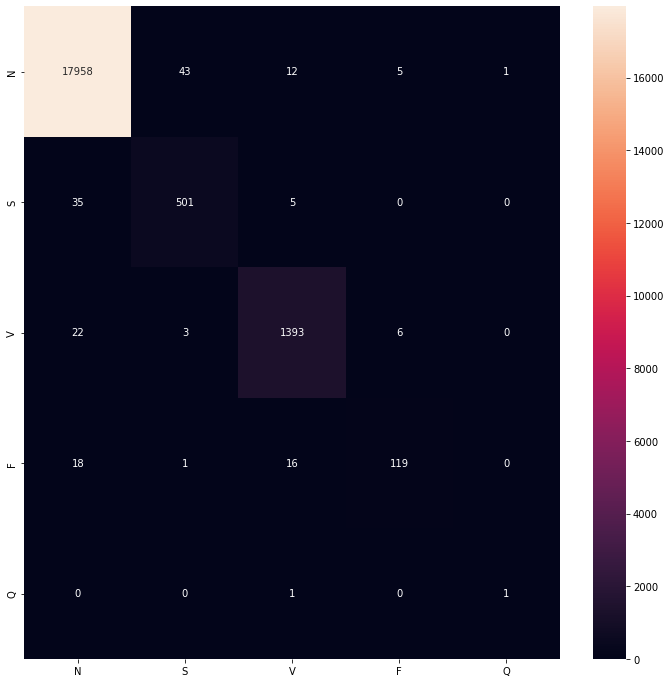

In [18]:
def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions,average="micro")))
  print("Recall = {}".format(recall_score(labels, predictions,average="micro")))

def conf_matrix_ecg(predictions,y_test,class_types, session_path):
    ''' Plots conf. matrix and classification report '''
    print(class_types, len(class_types), y_test.shape)
    cm=confusion_matrix(y_test, np.argmax(np.round(predictions), axis=1),labels= np.arange(len(class_types)))
    print(cm)
    print_stats(np.argmax(np.round(predictions), axis=1), y_test)
    plt.figure(figsize=(12,12))
    sns_hmp = sns.heatmap(cm, annot=True, xticklabels = [class_types[i] for i in range(len(class_types))],
                yticklabels = [class_types[i] for i in range(len(class_types))], fmt="d")
    fig = sns_hmp.get_figure()
    fig.savefig(session_path+'confusion_matrix.png', dpi=250)
    cr=classification_report(y_test,
                                np.argmax(np.round(predictions), axis=1),labels= np.arange(len(class_types)),
                                target_names=[class_types[i] for i in range(len(class_types))])
    print(cr)


filepath = "ecg_transformer_acc_128-0.9902.h5" #il test va aggiornato di volta in volta con il nome del modello da testare
ViT_model.load_weights(filepath)

autotune = tf.data.AUTOTUNE


f = h5py.File('test.h5','r')
test_data = f['x_test'][:]
test_RR = f['RR_test'][:]
test_labels = f['test_lab_categorical'][:]
y_test = f['y_test'][:]
test_data = tf.data.Dataset.from_tensor_slices(test_data)
test_RR = tf.data.Dataset.from_tensor_slices(test_RR)
test_labels = tf.data.Dataset.from_tensor_slices(test_labels)
X_T = tf.data.Dataset.zip((test_data, test_RR)).map(lambda x1, x2: {'x1': x1, 'x2': x2})
XY_T = tf.data.Dataset.zip((X_T, test_labels))
test_ds = (XY_T.batch(batch_size).map(lambda x, y: (x, y), num_parallel_calls=autotune).prefetch(autotune))

pred_class_eeg = ViT_model.predict(test_ds, batch_size=1)

res_log = open("res_log_keras_out.txt","w")
print(pred_class_eeg.shape)

conf_matrix_ecg(pred_class_eeg, y_test,class_types,"./")